In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import datetime
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib as mpl
from matplotlib import pyplot as plt
import tqdm
import matplotlib.ticker as ticker

params = {
    "text.usetex": True,
    "figure.figsize": (8, 4),
    "lines.linewidth": 2,
    "font.serif": "Computer Modern Roman",
    "axes.labelsize": 14,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "savefig.dpi": 200,
    "savefig.format": "pdf",
    "savefig.bbox": "tight",
}

mpl.rcParams.update(params)

save_figs = False

from helper_functions import *

## Problem data

In [2]:
# Load and price data
load_data = pd.read_pickle("data/load_data.pickle")
price_data = pd.read_pickle("data/price_data.pickle")

# simulation window (1 year in 1h resolution)
T = 24 * 365
start_date = pd.Timestamp("2022-01-01 00:00:00")
sim_start_time = load_data.index.get_loc(start_date)
sim_end_time = sim_start_time + T
sim_index = load_data.index[sim_start_time:sim_end_time]
month_slices = get_month_slices(load_data[sim_start_time:sim_end_time].index)

# Problem data
p_load = load_data.iloc[sim_start_time:sim_end_time].values
Q = 15
C, D, q_init = Q/2, Q/2, Q/2
alpha = 0.01
eff_charge = 0.95
eff_discharge = 0.95
E = 20
price_buy = price_data.iloc[sim_start_time:sim_end_time].values

## Prescient optimization for linear peak cost

Optimal value: 20722.110251073307


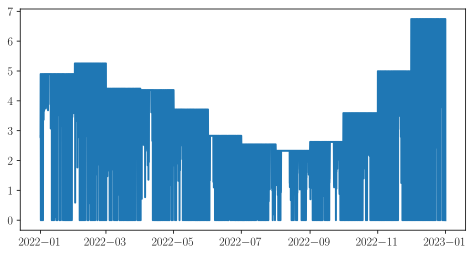

In [3]:
# Problem data
price_peak = 252

# Variables
p_grid = cp.Variable(T)
p_batt_in = cp.Variable(T)
p_batt_out = cp.Variable(T)
q = cp.Variable(T)

# Constraints
cons = [q[1:] == (1 - alpha) * q[:-1] + eff_charge * p_batt_in[:-1] 
        - (1/eff_discharge) * p_batt_out[:-1],
        q[0] == q_init, q[-1] == q_init, q <= Q, q >= 0,
        p_batt_in >= 0, p_batt_in <= C, p_batt_out >= 0, p_batt_out <= D,
        p_grid >= 0, p_grid <= E,
        p_grid + p_batt_out == p_batt_in + p_load]

# Objective
cost_usage = cp.sum(cp.multiply(price_buy, p_grid))
cost_peak = cp.sum([price_peak * cp.max(p_grid[month]) for month in month_slices])
cost = cost_usage + cost_peak

# Formulate problem and solve
prescient_linear = cp.Problem(cp.Minimize(cost), cons)
prescient_linear.solve()

# Report results:
print("Optimal value: {}".format(prescient_linear.value))

plt.figure()
plt.plot(sim_index, p_grid.value)

## Prescient optimization for tiered peak cost

In [4]:
# Define the ranges for the peak powers and their corresponding peak prices
peak_power_tiers = [(0, 2), (2, 5), (5, 10), (10, 15), (15, 20)]
peak_prices = [83, 147, 252, 371, 490]

# Initialize lists for coefficients
a_coeffs = []
b_coeffs = []

for i in range(len(peak_power_tiers)):
    x1, x2 = peak_power_tiers[i]

    if i == 0:
        y1 = 0
    else:
        y1 = a_coeffs[-1] * x1 + b_coeffs[-1]

    y2 = peak_prices[i] * x2

    a_i = (y2 - y1) / (x2 - x1)
    b_i = y1 - a_i * x1

    a_coeffs.append(a_i)
    b_coeffs.append(b_i)


def peak_price_lookup_single(peak_power):
    peak_power_tiers = [(0, 2), (2, 5), (5, 10), (10, 15), (15, 20)]
    peak_prices = [83, 147, 252, 371, 490]

    for i, (lower, upper) in enumerate(peak_power_tiers):
        if lower <= peak_power < upper:
            return peak_prices[i]

    # If peak_power is not within the defined range, you can return an error or a default value
    raise ValueError("The provided peak power value is outside the defined range.")

def peak_price_lookup(peak_powers):
    peak_powers = np.array(peak_powers)
    vectorized_lookup = np.vectorize(peak_price_lookup_single)
    prices = vectorized_lookup(peak_powers)
    return prices

def peak_power_bound_lookup(peak_powers):
    peak_power_tiers = [(0, 2), (2, 5), (5, 10), (10, 15), (15, 20)]

    def find_bounds(peak_power):
        for lower, upper in peak_power_tiers:
            if lower <= peak_power < upper:
                return lower, upper
        raise ValueError("The provided peak power value is outside the defined range.")

    peak_powers = np.array(peak_powers)
    vectorized_find_bounds = np.vectorize(find_bounds, otypes=[int, int])
    peak_lb, peak_ub = vectorized_find_bounds(peak_powers)
    return peak_lb, peak_ub

# # Test the lookup function
# peak_powers = np.array([1, 3, 7, 12, 18])
# peak_lb, peak_ub = peak_power_bound_lookup(peak_powers)
# print(f"The lower bounds for peak powers {peak_powers} are {peak_lb}")
# print(f"The upper bounds for peak powers {peak_powers} are {peak_ub}")


First pass

Optimal value after first pass: 15487.262126013986


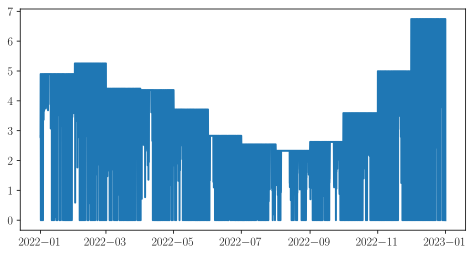

In [5]:
# Define new variable for monthly peaks
p_peak = cp.Variable(len(month_slices))

# Define new peak cost (lower convex envelope of original peak cost)
cost_peak = 0
for month in range(len(month_slices)):
    cost_tiers = cp.vstack([a * p_peak[month] + b for a, b in zip(a_coeffs, b_coeffs)])
    cost_relaxed = cp.max(cost_tiers)
    cost_peak += cost_relaxed

cost = cost_usage + cost_peak
    
# Add constrints for monthly peaks
cons.extend([p_peak[i] >= cp.max(p_grid[month]) for i, month in enumerate(month_slices)])

# Formulate problem and solve
cost_lb = cp.Problem(cp.Minimize(cost), cons)
cost_lb.solve()

# Report results:

# print("Monthly peaks after first pass: {}".format(p_peak.value))
# print("Monthly peak prices after first pass: {}".format(peak_price_lookup(p_peak.value)))

print("Optimal value after first pass: {}".format(cost_lb.value))

plt.figure()
plt.plot(sim_index, p_grid.value)

Second pass

Optimal value after second pass: 16913.4795074027
Absolute gap: 1426.22
Relative gap: 8.43%
Gap range: [15487.26, 16913.48]
Lower bound: 15487.26
Upper bound: 16913.48


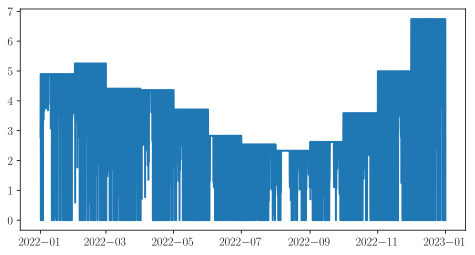

In [6]:
# Modify peak cost by fixing the peak prices
price_peak = peak_price_lookup(p_peak.value)

cost_peak = cp.sum([price_peak[i] * cp.max(p_grid[month]) for i, month in enumerate(month_slices)])
cost = cost_usage + cost_peak

# Add constraints limiting the peak power to stay in their ranges
peak_lb, peak_ub = peak_power_bound_lookup(p_peak.value)
cons.extend([p_peak >= peak_lb, p_peak <= peak_ub])

# Create and solve problem
cost_ub = cp.Problem(cp.Minimize(cost), cons)
cost_ub.solve()

print("Optimal value after second pass: {}".format(cost_ub.value))

# Compute and report the gap
# Calculate the absolute and relative gaps
absolute_gap = cost_ub.value - cost_lb.value
relative_gap = absolute_gap / abs(cost_ub.value)

# Print the gaps and the bounds
print(f"Absolute gap: {absolute_gap:.2f}")
print(f"Relative gap: {relative_gap * 100:.2f}%")
print(f"Gap range: [{cost_lb.value:.2f}, {cost_ub.value:.2f}]")
print(f"Lower bound: {cost_lb.value:.2f}")
print(f"Upper bound: {cost_ub.value:.2f}")

plt.figure()
plt.plot(sim_index, p_grid.value)
